# TensorFlow 那些事儿之DL中的 HELLO WORLD

- 基于MNIST数据集，运用TensorFlow搭建一个简单的卷积神经网络，并实现模型训练/验证/测试

- TensorBoard的简单使用


## 看看MNIST数据长什么样子的

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

## 流程图

下面的图表直接显示了之后实现的卷积神经网络中数据的传递。

![Flowchart](images/02_network_flowchart.png)

输入图像在第一层卷积层里使用权重过滤器处理。结果在16张新图里，每张代表了卷积层里一个过滤器（的处理结果）。图像经过降采样，分辨率从28x28减少到14x14。

16张小图在第二个卷积层中处理。这16个通道以及这层输出的每个通道都需要一个过滤权重。总共有36个输出，所以在第二个卷积层有16 x 36 = 576个滤波器。输出图再一次降采样到7x7个像素。

第二个卷积层的输出是36张7x7像素的图像。它们被转换到一个长为7 x 7 x 36 = 1764的向量中去，它作为一个有128个神经元（或元素）的全连接网络的输入。这些又输入到另一个有10个神经元的全连接层中，每个神经元代表一个类别，用来确定图像的类别，即图像上的数字。

卷积滤波一开始是随机挑选的，因此分类也是随机完成的。根据交叉熵（cross-entropy）来测量输入图预测值和真实类别间的错误。然后优化器用链式法则自动地将这个误差在卷积网络中传递，更新滤波权重来提升分类质量。这个过程迭代了几千次，直到分类误差足够低。

这些特定的滤波权重和中间图像是一个优化结果，和你执行代码所看到的可能会有所不同。

注意，这些在TensorFlow上的计算是在一部分图像上执行，而非单独的一张图，这使得计算更有效。也意味着在TensorFlow上实现时，这个流程图实际上会有更多的数据维度。


## 各种库导入

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta
import math

使用Python3.6（Anaconda）开发，TensorFlow版本是：

In [4]:
tf.__version__

'1.8.0'

## MNIST数据集导入

- 现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集。

- 定义**MNIST**数据的相关信息

In [3]:
TRAIN_DATA_FILES_PATTERN = 'data_csv/mnist_train.csv'
VAL_DATA_FILES_PATTERN = 'data_csv/mnist_val.csv'
TEST_DATA_FILES_PATTERN = 'data_csv/mnist_test.csv'

MULTI_THREADING = True
RESUME_TRAINING = False

NUM_CLASS = 10
IMG_SHAPE = [28,28]

IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_FLAT = 784
NUM_CHANNEL = 1

BATCH_SIZE = 128
NUM_TRAIN = 55000
NUM_VAL = 5000
NUM_TEST = 10000

In [4]:
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN)
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None, names=HEADER )
train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None)
test_data = pd.read_csv(TEST_DATA_FILES_PATTERN, header=None)
val_data = pd.read_csv(VAL_DATA_FILES_PATTERN, header=None)

train_values = train_data.values
train_data = train_values[:,1:]/255.0
train_label = train_values[:,0:1].squeeze()

val_values = val_data.values
val_data = val_values[:,1:]/255.0
val_label = val_values[:,0:1].squeeze()

test_values = test_data.values
test_data = test_values[:,1:]/255.0
test_label = test_values[:,0:1].squeeze()

print('test_data',np.shape(test_data))
print('test_label',np.shape(test_label))

print('val_data',np.shape(val_data))
print('val_label',np.shape(val_label))

print('train_data',np.shape(train_data))
print('train_label',np.shape(train_label))

# train_data.head(10)
# test_data.head(10)

test_data (10000, 784)
test_label (10000,)
val_data (5000, 784)
val_label (5000,)
train_data (55000, 784)
train_label (55000,)


### one-hot编码

In [5]:
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.

    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]

    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.

    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.

    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

### 数据集batch处理

In [45]:
# idx = 0

def batch(batch_size=32):
    """
    Create a random batch of training-data.

    :param batch_size: Number of images in the batch.
    :return: 3 numpy arrays (x, y, y_cls)
    """
#     global idx
    # Create a random index into the training-set.
    idx = np.random.randint(low=0, high=NUM_TRAIN, size=batch_size)
#     idx = iterations
    # Use the index to lookup random training-data.
    x_batch = train_data[idx]
    y_batch = train_label_onehot[idx]
    y_batch_cls = train_label[idx]
#     idx = idx + batch_size
#     print('IDX',idx)
    return x_batch, y_batch, y_batch_cls


In [7]:
train_label_onehot = one_hot_encoded(train_label.T,10).squeeze()
print('shape',np.shape(train_label_onehot))
print(train_label_onehot)

shape (55000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## 神经网络的配置

方便起见，在这里定义神经网络的配置，你可以很容易找到或改变这些数值，然后重新运行Notebook。

In [8]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### 用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [9]:
img_shape = IMG_SHAPE

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制几张图像来看看数据是否正确

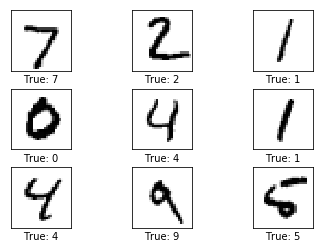

In [10]:
# Get the first images from the test-set.
images = test_data[0:9]

# Get the true classes for those images.
cls_true = test_label[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow图

TensorFlow的全部目的就是使用一个称之为计算图（computational graph）的东西，它会比直接在Python中进行相同计算量要高效得多。TensorFlow比Numpy更高效，因为TensorFlow了解整个需要运行的计算图，然而Numpy只知道某个时间点上唯一的数学运算。

TensorFlow也能够自动地计算需要优化的变量的梯度，使得模型有更好的表现。这是由于图是简单数学表达式的结合，因此整个图的梯度可以用链式法则推导出来。

TensorFlow还能利用多核CPU和GPU，Google也为TensorFlow制造了称为TPUs（Tensor Processing Units）的特殊芯片，它比GPU更快。

一个TensorFlow图由下面几个部分组成，后面会详细描述：

* 占位符变量（Placeholder）用来改变图的输入。
* 模型变量（Model）将会被优化，使得模型表现得更好。
* 模型本质上就是一些数学函数，它根据Placeholder和模型的输入变量来计算一些输出。
* 一个cost度量用来指导变量的优化。
* 一个优化策略会更新模型的变量。

另外，TensorFlow图也包含了一些调试状态，比如用TensorBoard打印log数据。

### 创建新变量的帮助函数

函数用来根据给定大小创建TensorFlow变量，并将它们用随机值初始化。需注意的是在此时并未完成初始化工作，仅仅是在TensorFlow图里定义它们。

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### 创建卷积层的帮助函数

这个函数为TensorFlow在计算图里创建了新的卷积层。这里并没有执行什么计算，只是在TensorFlow图里添加了数学公式。

假设输入的是四维的张量，各个维度如下：

1. 图像数量
2. 每张图像的Y轴
3. 每张图像的X轴
4. 每张图像的通道数

输入通道可能是彩色通道，当输入是前面的卷积层生成的时候，它也可能是滤波通道。

输出是另外一个4通道的张量，如下：

1. 图像数量，与输入相同
2. 每张图像的Y轴。如果用到了2x2的池化，是输入图像宽高的一半。
3. 每张图像的X轴。同上。
4. 卷积滤波生成的通道数。

In [20]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### 转换一个层的帮助函数

卷积层生成了4维的张量。我们会在卷积层之后添加一个全连接层，因此我们需要将这个4维的张量转换成可被全连接层使用的2维张量。

In [13]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 创建一个全连接层的帮助函数

这个函数为TensorFlow在计算图中创建了一个全连接层。这里也不进行任何计算，只是往TensorFlow图中添加数学公式。

输入是大小为`[num_images, num_inputs]`的二维张量。输出是大小为`[num_images, num_outputs]`的2维张量。

In [14]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，每次我们运行图的时候都可能会改变它们。将这个过程称为feeding placeholder变量，后面将会描述它。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [15]:
img_size_flat = IMG_FLAT

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

卷积层希望`x`被编码为4维张量，因此我们需要将它的形状转换至`[num_images, img_height, img_width, num_channels]`。注意`img_height == img_width == img_size`，如果第一维的大小设为-1， `num_images`的大小也会被自动推导出来。转换运算如下：

In [16]:
img_size = IMG_HEIGHT
num_channels = NUM_CHANNEL

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [17]:
num_classes = NUM_CLASS

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

我们也可以为class-number提供一个placeholder，但这里用argmax来计算它。这里只是TensorFlow中的一些操作，没有执行什么运算。

In [18]:
y_true_cls = tf.argmax(y_true, axis=1)

### 卷积层 1

创建第一个卷积层。将`x_image`当作输入，创建`num_filters1`个不同的滤波器，每个滤波器的宽高都与 `filter_size1`相等。最终我们会用2x2的max-pooling将图像降采样，使它的尺寸减半。

In [21]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

检查卷积层输出张量的大小。它是（？,14, 14, 16），这代表着有任意数量的图像（？代表数量），每张图像有14个像素的宽和高，有16个不同的通道，每个滤波器各有一个通道。

In [22]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### 卷积层 2

创建第二个卷积层，它将第一个卷积层的输出作为输入。输入通道的数量对应着第一个卷积层的滤波数。

In [23]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

核对一下这个卷积层输出张量的大小。它的大小是（？， 7， 7， 36）,其中？也代表着任意数量的图像，每张图有7像素的宽高，每个滤波器有36个通道。

In [24]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### 转换层

这个卷积层输出一个4维张量。现在我们想将它作为一个全连接网络的输入，这就需要将它转换成2维张量。

In [25]:
layer_flat, num_features = flatten_layer(layer_conv2)

这个张量的大小是（？， 1764），意味着共有一定数量的图像，每张图像被转换成长为1764的向量。其中1764 = 7 x 7 x 36。

In [26]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [27]:
num_features

1764

### 全连接层 1

往网络中添加一个全连接层。输入是一个前面卷积得到的被转换过的层。全连接层中的神经元或节点数为`fc_size`。我们可以用ReLU来学习非线性关系。

In [28]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

全连接层的输出是一个大小为（？，128）的张量，？代表着一定数量的图像，并且`fc_size` == 128。

In [29]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### 全连接层 2

添加另外一个全连接层，它的输出是一个长度为10的向量，它确定了输入图是属于哪个类别。这层并没有用到ReLU。

In [30]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [31]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### 预测类别

第二个全连接层估算了输入图有多大的可能属于10个类别中的其中一个。然而，这是很粗略的估计并且很难解释，因为数值可能很小或很大，因此我们会对它们做归一化，将每个元素限制在0到1之间，并且相加为1。这用一个称为softmax的函数来计算的，结果保存在`y_pred`中。

In [32]:
y_pred = tf.nn.softmax(layer_fc2)

类别数字是最大元素的索引。

In [33]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### 优化损失函数

为了使模型更好地对输入图像进行分类，我们必须改变`weights`和`biases`变量。首先我们需要对比模型`y_pred`的预测输出和期望输出的`y_true`，来了解目前模型的性能如何。

交叉熵（cross-entropy）是在分类中使用的性能度量。交叉熵是一个常为正值的连续函数，如果模型的预测值精准地符合期望的输出，它就等于零。因此，优化的目的就是通过改变网络层的变量来最小化交叉熵。

TensorFlow有一个内置的计算交叉熵的函数。这个函数内部计算了softmax，所以我们要用`layer_fc2`的输出而非直接用`y_pred`,因为`y_pred`上已经计算了softmax。

In [34]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



我们为每个图像分类计算了交叉熵，所以有一个当前模型在每张图上表现的度量。但是为了用交叉熵来指导模型变量的优化，我们需要一个额外的标量值，因此简单地利用所有图像分类交叉熵的均值。

In [35]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

既然我们有一个需要被最小化的损失度量，接着就可以建立优化一个优化器。这个例子中，我们使用的是梯度下降的变体`AdamOptimizer`。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便之后的操作。

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

这是一个布尔值向量，代表预测类型是否等于每张图片的真实类型。

In [37]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [38]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [39]:
session = tf.Session()

In [47]:
train_log_save_dir = '/Users/honglan/Desktop/tensorflow_estimator_learn/cnn_raw_log'
model_save_path = '/Users/honglan/Desktop/tensorflow_estimator_learn/cnn_raw'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_save_dir, session.graph)
saver = tf.train.Saver()

### 初始化变量

我们需要在开始优化weights和biases变量之前对它们进行初始化。

In [41]:
session.run(tf.global_variables_initializer())

### 用来优化迭代的帮助函数

在训练集中有50,000张图。用这些图像计算模型的梯度会花很多时间。因此我们利用随机梯度下降的方法，它在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [42]:
train_batch_size = 64

函数执行了多次的优化迭代来逐步地提升网络层的变量。在每次迭代中，从训练集中选择一批新的数据，然后TensorFlow用这些训练样本来执行优化器。每100次迭代会打印出相关信息。

In [48]:
# Counter for total number of iterations performed so far.
total_iterations = 0


def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc,summary = session.run([accuracy,merged], feed_dict=feed_dict_train)
            train_writer.add_summary(summary,total_iterations)
            
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            saver.save(sess=session, save_path=model_save_path+'/'+'cnn_raw',global_step=total_iterations)
        
            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 终于可以开始训练了

In [49]:
optimize(1000)

Optimization Iteration:      1, Training Accuracy:  95.3%
Optimization Iteration:    101, Training Accuracy:  95.3%
Optimization Iteration:    201, Training Accuracy:  95.3%
Optimization Iteration:    301, Training Accuracy:  90.6%
Optimization Iteration:    401, Training Accuracy:  93.8%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  98.4%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  98.4%
Time usage: 0:01:31


### 关闭TensorFlow会话

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。

In [50]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

## 总结

- 常规TensorFlow模型训练的步骤，大家应该都了解

- 有没有觉得有点费劲，训练和验证还没有写，我已经懒得写了（留给大家有兴趣的自己写一写）
